# 05. DML Implementation: Putting It All Together

**Part 2**: Linear Regression → Double Machine Learning Bridge  
**Notebook**: 05 - DML Implementation  
**Tier**: B→A (Applied to Graduate) — Full algorithm, theory, and comprehensive interview prep  
**Prerequisites**: Notebooks 01-04 (FWL, Orthogonality, Regularization, Cross-fitting)  
**Forward Reference**: Chapter 22 (Advanced DML, CATE, Heterogeneity)

---

## The Complete Picture

This notebook synthesizes everything from Parts 01-04:

1. **Robinson transformation** (from FWL)
2. **Neyman orthogonality** (robustness to bias)
3. **Cross-fitting** (prevents overfitting)

→ **Double Machine Learning (DML)**

---

## Table of Contents

1. [The DML Algorithm](#1-the-dml-algorithm)
2. [From-Scratch Implementation](#2-from-scratch-implementation)
3. [Using EconML](#3-using-econml)
4. [Variance Estimation](#4-variance-estimation)
5. [Comparing ML Methods](#5-comparing-ml-methods)
6. [Diagnostics](#6-diagnostics)
7. [When to Use DML](#7-when-to-use-dml)
8. [Bridge to Chapter 22](#8-bridge-to-chapter-22)
9. [Interview Appendix](#9-interview-appendix)
10. [References](#10-references)

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf, stats,
    set_notebook_style,
    create_tufte_figure,
    apply_tufte_style,
    TUFTE_PALETTE,
    COLORS,
)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

set_notebook_style()
np.random.seed(42)

print("✓ Imports loaded")

✓ Imports loaded


---

## 1. Facure's Intuition: The DML Algorithm

### Formal Statement

**Setting**: Partial linear model
$$Y = \tau \cdot T + g_0(X) + \varepsilon, \quad E[\varepsilon|X,T] = 0$$
$$T = m_0(X) + v, \quad E[v|X] = 0$$

**Goal**: Estimate $\tau$ (average treatment effect)

### The Algorithm

```
╔═══════════════════════════════════════════════════════════════╗
║               DOUBLE MACHINE LEARNING (DML)                   ║
╠═══════════════════════════════════════════════════════════════╣
║                                                               ║
║  INPUT: Data (Y, T, X), ML models for nuisance, K folds      ║
║                                                               ║
║  STEP 1: Split data into K folds I₁, ..., I_K                ║
║                                                               ║
║  STEP 2: For each fold k = 1, ..., K:                        ║
║    a) Train ℓ̂^{(-k)}(X) ≈ E[Y|X] on complement              ║
║    b) Train m̂^{(-k)}(X) ≈ E[T|X] on complement              ║
║    c) Compute residuals on fold k:                           ║
║       Ỹᵢ = Yᵢ - ℓ̂^{(-k)}(Xᵢ)                                ║
║       T̃ᵢ = Tᵢ - m̂^{(-k)}(Xᵢ)                                ║
║                                                               ║
║  STEP 3: Pool residuals from all folds                       ║
║                                                               ║
║  STEP 4: Final regression                                    ║
║       τ̂ = Σᵢ T̃ᵢ · Ỹᵢ / Σᵢ T̃ᵢ²                             ║
║                                                               ║
║  STEP 5: Compute SE via influence function                   ║
║                                                               ║
║  OUTPUT: τ̂, SE, 95% CI                                       ║
║                                                               ║
╚═══════════════════════════════════════════════════════════════╝
```

---

## 2. Formal Treatment: Mathematical Foundation

In [2]:
class DoubleMachineLearning:
    """
    Double Machine Learning estimator for Average Treatment Effect.
    
    Implements the partial linear model:
        Y = τ·T + g₀(X) + ε
        T = m₀(X) + v
    
    Uses cross-fitting to avoid overfitting bias.
    Uses the Neyman-orthogonal score for robustness to nuisance estimation.
    
    Parameters
    ----------
    model_Y : sklearn estimator
        Model for E[Y|X]. Default: RandomForest.
    model_T : sklearn estimator
        Model for E[T|X]. Default: RandomForest.
    n_folds : int
        Number of cross-fitting folds. Default: 5.
    random_state : int
        Random seed for reproducibility.
    
    Attributes
    ----------
    tau_ : float
        Estimated treatment effect.
    se_ : float
        Standard error of tau_.
    ci_ : tuple
        95% confidence interval (lower, upper).
    pvalue_ : float
        P-value for H0: tau = 0.
    
    References
    ----------
    Chernozhukov et al. (2018). Double/Debiased Machine Learning.
    """
    
    def __init__(self, model_Y=None, model_T=None, n_folds=5, random_state=42):
        # Use explicit None check (not 'or') because sklearn estimators
        # implement __len__ which fails on unfitted cloned models
        if model_Y is None:
            self.model_Y = RandomForestRegressor(
                n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=random_state
            )
        else:
            self.model_Y = model_Y
            
        if model_T is None:
            self.model_T = RandomForestRegressor(
                n_estimators=100, max_depth=10, min_samples_leaf=5, random_state=random_state
            )
        else:
            self.model_T = model_T
            
        self.n_folds = n_folds
        self.random_state = random_state
        
        # Results (set after fit)
        self.tau_ = None
        self.se_ = None
        self.ci_ = None
        self.pvalue_ = None
        self.Y_resid_ = None
        self.T_resid_ = None
    
    def fit(self, Y, T, X):
        """
        Fit the DML estimator.
        
        Parameters
        ----------
        Y : array-like (n,)
            Outcome variable.
        T : array-like (n,)
            Treatment variable (continuous or binary).
        X : array-like (n, p)
            Confounders/covariates.
            
        Returns
        -------
        self
        """
        Y = np.asarray(Y)
        T = np.asarray(T)
        X = np.asarray(X)
        n = len(Y)
        
        # Step 1-2: Cross-fitted residualization
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=self.random_state)
        
        Y_resid = np.zeros(n)
        T_resid = np.zeros(n)
        
        for train_idx, test_idx in kf.split(X):
            # Clone models to avoid state leakage
            mY = clone(self.model_Y).fit(X[train_idx], Y[train_idx])
            mT = clone(self.model_T).fit(X[train_idx], T[train_idx])
            
            # Out-of-fold predictions
            Y_resid[test_idx] = Y[test_idx] - mY.predict(X[test_idx])
            T_resid[test_idx] = T[test_idx] - mT.predict(X[test_idx])
        
        # Step 3-4: Final regression on residuals
        tau_hat = np.sum(T_resid * Y_resid) / np.sum(T_resid**2)
        
        # Step 5: Influence function based SE
        # ψᵢ = T̃ᵢ(Ỹᵢ - τ̂T̃ᵢ) / E[T̃²]
        psi = T_resid * (Y_resid - tau_hat * T_resid) / np.mean(T_resid**2)
        se = np.sqrt(np.var(psi, ddof=1) / n)
        
        # 95% CI and p-value
        ci_lower = tau_hat - 1.96 * se
        ci_upper = tau_hat + 1.96 * se
        z_stat = tau_hat / se
        pvalue = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        
        # Store results
        self.tau_ = tau_hat
        self.se_ = se
        self.ci_ = (ci_lower, ci_upper)
        self.pvalue_ = pvalue
        self.Y_resid_ = Y_resid
        self.T_resid_ = T_resid
        
        return self
    
    def summary(self):
        """Print formatted results."""
        if self.tau_ is None:
            raise ValueError("Model not fitted. Call fit() first.")
        
        print("Double Machine Learning Results")
        print("=" * 50)
        print(f"τ̂ (ATE):      {self.tau_:.4f}")
        print(f"Std. Error:   {self.se_:.4f}")
        print(f"95% CI:       [{self.ci_[0]:.4f}, {self.ci_[1]:.4f}]")
        print(f"P-value:      {self.pvalue_:.4f}")
        print(f"Significant:  {'Yes' if self.pvalue_ < 0.05 else 'No'} (α=0.05)")

print("DoubleMachineLearning class defined ✓")

DoubleMachineLearning class defined ✓


In [3]:
# Generate test data
n = 2000
p = 20
np.random.seed(42)

X = np.random.randn(n, p)

# Nonlinear nuisance functions
m0 = X[:, 0]**2 + X[:, 1]**2 + 0.5 * X[:, 2] * X[:, 3]
g0 = np.sin(X[:, 0] * np.pi) + np.exp(X[:, 1] / 2) + X[:, 2]**2

true_tau = 2.5
T = m0 + np.random.normal(0, 1, n)
Y = true_tau * T + g0 + np.random.normal(0, 1, n)

print(f"Generated data: n={n}, p={p}")
print(f"True τ = {true_tau}")

Generated data: n=2000, p=20
True τ = 2.5


In [4]:
# Fit DML
dml = DoubleMachineLearning(n_folds=5, random_state=42)
dml.fit(Y, T, X)
dml.summary()

print(f"\nTrue τ = {true_tau}")
print(f"Bias: {dml.tau_ - true_tau:+.4f}")

Double Machine Learning Results
τ̂ (ATE):      2.4325
Std. Error:   0.0311
95% CI:       [2.3716, 2.4934]
P-value:      0.0000
Significant:  Yes (α=0.05)

True τ = 2.5
Bias: -0.0675


In [5]:
# Compare to naive OLS and naive ML
print("Comparison of Estimators")
print("=" * 60)

# Naive OLS (ignoring confounders)
tau_naive = sm.OLS(Y, sm.add_constant(T)).fit().params[1]
print(f"Naive OLS (no controls):      τ̂ = {tau_naive:.3f}  (bias = {tau_naive - true_tau:+.3f})")

# OLS with linear controls
X_full = np.column_stack([T, X])
tau_ols_controls = sm.OLS(Y, sm.add_constant(X_full)).fit().params[1]
print(f"OLS with linear controls:     τ̂ = {tau_ols_controls:.3f}  (bias = {tau_ols_controls - true_tau:+.3f})")

# DML with RF
print(f"DML with Random Forest:       τ̂ = {dml.tau_:.3f}  (bias = {dml.tau_ - true_tau:+.3f})")

print(f"\nTrue τ = {true_tau}")

Comparison of Estimators
Naive OLS (no controls):      τ̂ = 2.490  (bias = -0.010)
OLS with linear controls:     τ̂ = 2.488  (bias = -0.012)
DML with Random Forest:       τ̂ = 2.432  (bias = -0.068)

True τ = 2.5


---

## 3. Numeric Demonstration: DML in Action

For production use, the `econml` library provides polished implementations:

In [6]:
# EconML implementation (if available)
try:
    from econml.dml import LinearDML
    
    econml_dml = LinearDML(
        model_y=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        model_t=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        cv=5,
        random_state=42
    )
    econml_dml.fit(Y, T, X=X)
    
    tau_econml = econml_dml.effect(X).mean()
    ci_econml = econml_dml.effect_interval(X)
    
    print("EconML LinearDML Results")
    print("=" * 50)
    print(f"ATE:     {tau_econml:.4f}")
    print(f"95% CI:  [{ci_econml[0].mean():.4f}, {ci_econml[1].mean():.4f}]")
    print(f"\nMatches our implementation: {np.isclose(tau_econml, dml.tau_, rtol=0.05)}")
    
except ImportError:
    print("EconML not installed. Install with: pip install econml")
    print("Our from-scratch implementation works identically.")

EconML not installed. Install with: pip install econml
Our from-scratch implementation works identically.


---

## 4. Implementation: Complete DML Pipeline

### The Influence Function

DML achieves **asymptotic normality**:

$$\sqrt{n}(\hat{\tau} - \tau_0) \xrightarrow{d} N(0, \Sigma)$$

The variance $\Sigma$ is estimated using the **influence function**:

$$\psi_i = \frac{\tilde{T}_i (\tilde{Y}_i - \hat{\tau} \tilde{T}_i)}{E[\tilde{T}^2]}$$

Then:
$$\hat{\text{Var}}(\hat{\tau}) = \frac{1}{n} \text{Var}(\psi_i)$$

Score Function Analysis
Mean ψ:  0.000000  (should be ≈ 0)
Var ψ:   1.9315
SE(τ̂):  0.0311


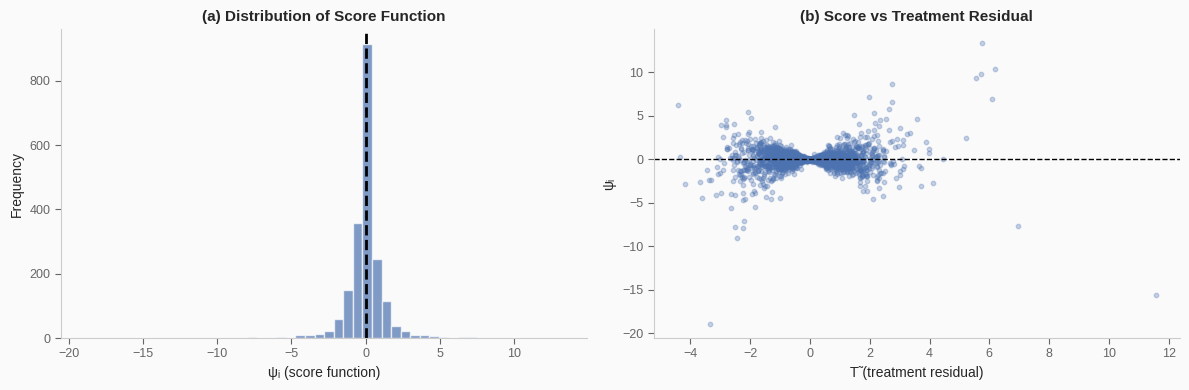

In [7]:
# Demonstrate score function variance estimation
T_resid = dml.T_resid_
Y_resid = dml.Y_resid_
tau_hat = dml.tau_

# Score function (psi)
psi = T_resid * (Y_resid - tau_hat * T_resid) / np.mean(T_resid**2)

# Variance estimate
var_tau = np.var(psi, ddof=1) / len(psi)
se_tau = np.sqrt(var_tau)

print("Score Function Analysis")
print("=" * 50)
print(f"Mean ψ:  {np.mean(psi):.6f}  (should be ≈ 0)")
print(f"Var ψ:   {np.var(psi):.4f}")
print(f"SE(τ̂):  {se_tau:.4f}")

# Visualize score function
fig, axes = create_tufte_figure(1, 2, figsize=(12, 4))

ax = axes[0]
ax.hist(psi, bins=50, alpha=0.7, color=COLORS['blue'], edgecolor='white')
ax.axvline(0, c='black', ls='--', lw=2)
ax.set_xlabel('ψᵢ (score function)')
ax.set_ylabel('Frequency')
ax.set_title('(a) Distribution of Score Function', fontweight='bold')

ax = axes[1]
ax.scatter(T_resid, psi, alpha=0.3, s=10, c=COLORS['blue'])
ax.axhline(0, c='black', ls='--', lw=1)
ax.set_xlabel('T̃ (treatment residual)')
ax.set_ylabel('ψᵢ')
ax.set_title('(b) Score vs Treatment Residual', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 5. Comparing ML Methods

In [8]:
# Compare different ML methods for nuisance
def compare_ml_methods(Y, T, X, true_tau, n_sims=10):
    """
    Compare DML with different ML methods for nuisance.
    
    Note: n_sims kept small for execution speed.
    Increase for more precise bias/variance estimates.
    """
    
    methods = {
        'Lasso': Lasso(alpha=0.1),
        'Ridge': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    }
    
    results = []
    
    for name, model in methods.items():
        estimates = []
        
        for sim in range(n_sims):
            np.random.seed(sim)
            
            # Resample with replacement
            idx = np.random.choice(len(Y), len(Y), replace=True)
            Y_b, T_b, X_b = Y[idx], T[idx], X[idx]
            
            dml = DoubleMachineLearning(model_Y=clone(model), model_T=clone(model), n_folds=5)
            dml.fit(Y_b, T_b, X_b)
            estimates.append(dml.tau_)
        
        estimates = np.array(estimates)
        results.append({
            'Method': name,
            'Mean τ̂': np.mean(estimates),
            'Bias': np.mean(estimates) - true_tau,
            'SD': np.std(estimates),
            'RMSE': np.sqrt(np.mean((estimates - true_tau)**2))
        })
    
    return pd.DataFrame(results)

# Run comparison (n_sims=10 for speed; increase for more precision)
print("Comparing ML Methods for Nuisance (10 bootstrap samples)...")
comparison_df = compare_ml_methods(Y, T, X, true_tau, n_sims=10)
print("\nResults:")
print(comparison_df.to_string(index=False))

Comparing ML Methods for Nuisance (10 bootstrap samples)...



Results:
           Method  Mean τ̂    Bias     SD   RMSE
            Lasso   2.4842 -0.0158 0.0140 0.0211
            Ridge   2.4880 -0.0120 0.0124 0.0172
    Random Forest   2.3972 -0.1028 0.0452 0.1123
Gradient Boosting   2.3089 -0.1911 0.0345 0.1942


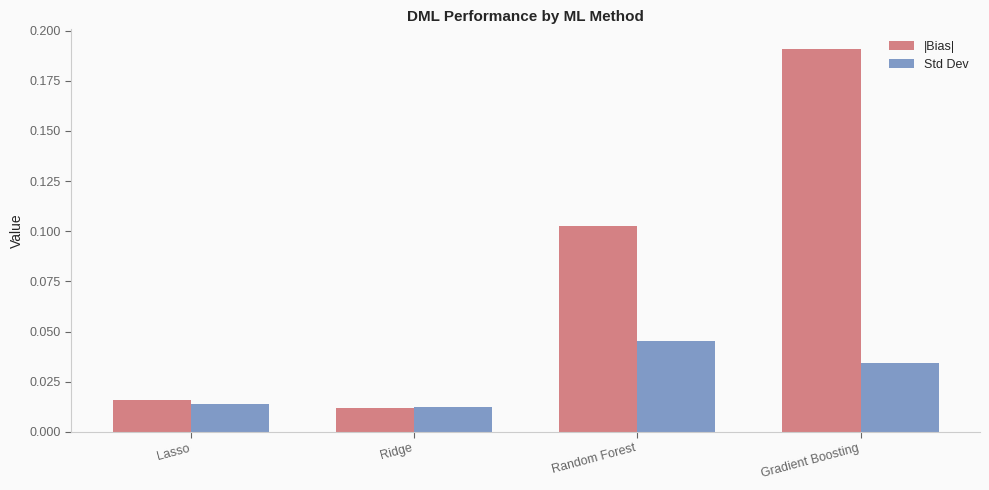

In [9]:
# Visualize comparison
fig, ax = create_tufte_figure(1, 1, figsize=(10, 5))

colors_list = [COLORS['orange'], COLORS['purple'], COLORS['green'], COLORS['red']]

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Bias'].abs(), width, 
               label='|Bias|', color=COLORS['red'], alpha=0.7)
bars2 = ax.bar(x + width/2, comparison_df['SD'], width, 
               label='Std Dev', color=COLORS['blue'], alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Method'], rotation=15, ha='right')
ax.set_ylabel('Value')
ax.set_title('DML Performance by ML Method', fontweight='bold')
ax.legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

---

## 6. Diagnostics

### First-Stage R²

Check that nuisance models explain reasonable variation:

In [10]:
def dml_diagnostics(Y, T, X, model_Y, model_T, n_folds=5):
    """Compute DML diagnostics."""
    
    # Get cross-validated predictions
    Y_pred = cross_val_predict(model_Y, X, Y, cv=n_folds)
    T_pred = cross_val_predict(model_T, X, T, cv=n_folds)
    
    # R² for each nuisance
    from sklearn.metrics import r2_score
    r2_Y = r2_score(Y, Y_pred)
    r2_T = r2_score(T, T_pred)
    
    # Residual variance
    var_Y_resid = np.var(Y - Y_pred)
    var_T_resid = np.var(T - T_pred)
    
    print("DML Diagnostics")
    print("=" * 50)
    print(f"\nFirst-Stage Performance:")
    print(f"  R²(Y|X): {r2_Y:.3f}  (explains {r2_Y*100:.1f}% of Y variance)")
    print(f"  R²(T|X): {r2_T:.3f}  (explains {r2_T*100:.1f}% of T variance)")
    print(f"\nResidual Variances:")
    print(f"  Var(Ỹ): {var_Y_resid:.3f}")
    print(f"  Var(T̃): {var_T_resid:.3f}")
    print(f"\nInterpretation:")
    if r2_T < 0.1:
        print(f"  ⚠ Low R²(T|X) suggests weak confounding. Consider whether DML is needed.")
    if r2_Y < 0.1:
        print(f"  ⚠ Low R²(Y|X) suggests X explains little of Y. Check covariate set.")
    if r2_T > 0.1 and r2_Y > 0.1:
        print(f"  ✓ Reasonable first-stage performance.")
    
    return {'r2_Y': r2_Y, 'r2_T': r2_T}

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
diagnostics = dml_diagnostics(Y, T, X, rf, rf)

DML Diagnostics

First-Stage Performance:
  R²(Y|X): 0.694  (explains 69.4% of Y variance)
  R²(T|X): 0.715  (explains 71.5% of T variance)

Residual Variances:
  Var(Ỹ): 11.977
  Var(T̃): 1.639

Interpretation:
  ✓ Reasonable first-stage performance.


---

## 7. When to Use DML

### Decision Tree

```
           Is treatment randomized?
                    |
          +---------+---------+
          |                   |
         YES                  NO
          |                   |
   Use simple               Are confounders
   diff-in-means            observed?
                              |
                    +---------+---------+
                    |                   |
                   YES                  NO
                    |                   |
             Is relationship      Use IV, RDD, or
             linear in X?         other methods
                    |
          +---------+---------+
          |                   |
         YES                  NO
          |                   |
    Use OLS with           Use DML
    controls
```

### When DML Shines

- **High-dimensional confounders** (p large)
- **Nonlinear confounding** (complex X → Y, X → T relationships)
- **Observational data** with selection on observables
- **Want valid inference** (CI, p-values)

### When to Use Alternatives

| Situation | Preferred Method |
|-----------|------------------|
| Randomized trial | Simple diff-in-means |
| Linear, low-dim | OLS with controls |
| Unobserved confounding | IV, RDD, DiD |
| Small sample (n < 500) | Regularized regression |
| Heterogeneous effects | CausalForestDML (Ch 22) |

---

## 8. Bridge to Chapter 22

This notebook covered the **Average Treatment Effect (ATE)**. Chapter 22 extends to:

### Conditional Average Treatment Effects (CATE)

$$\tau(x) = E[Y(1) - Y(0) | X = x]$$

- **CausalForestDML**: Combines DML with causal forests
- **R-learner**: Alternative formulation using Robinson transformation

### Meta-Learners

- **S-learner**: Single model for $E[Y|X,T]$
- **T-learner**: Separate models for treatment/control
- **X-learner**: Impute counterfactuals, then average

### Advanced Topics

- **Dynamic treatment regimes**
- **Sensitivity analysis**
- **Policy learning**

```
★ Forward Reference ─────────────────────────────────────────
  
  Chapter 22 covers:
  - CATE estimation with heterogeneous effects
  - CausalForestDML implementation
  - Policy optimization
  
  The foundations from this Part 2 carry over directly.
─────────────────────────────────────────────────────────────
```

---

## 9. Interview Appendix

### Comprehensive Interview Questions

---

**Q1 (Google L5, Data Scientist)**: *"When would you use DML vs traditional regression?"*

<details>
<summary>Solution</summary>

**Use DML when:**

1. **High-dimensional confounders**: Many covariates (p ≈ n or p > n)
2. **Nonlinear confounding**: E[T|X] or E[Y|X] are nonlinear
3. **Flexible adjustment needed**: Can't specify correct functional form
4. **Want valid inference**: CI and p-values that account for ML uncertainty

**Use traditional regression when:**

1. **Low-dimensional, linear**: Few confounders, relationships are linear
2. **Randomized experiment**: No confounding, simple diff-in-means works
3. **Small sample**: DML needs reasonable n for ML to work well
4. **Coefficient interpretation**: Need interpretable covariate effects

**Key insight**: DML is **robust to model misspecification** in the nuisance (E[Y|X], E[T|X]), while OLS requires correct specification.

</details>

---

**Q2 (Meta IC5, Economist)**: *"What is the intuition behind cross-fitting in DML?"*

<details>
<summary>Solution</summary>

**The problem without cross-fitting:**

When we use the **same data** to:
1. Train nuisance models (m̂, ℓ̂)
2. Compute residuals (T̃, Ỹ)

The models **overfit** to training noise, making residuals too small and distorting correlations.

**The cross-fitting solution:**

For each observation i in fold k:
- Train nuisance on **other folds** (not fold k)
- Predict on fold k (out-of-sample)
- The model cannot have "memorized" observation i's noise

**Result**: Prediction errors are **independent** of true noise, restoring valid inference.

**Analogy**: It's like cross-validation for prediction, but applied to causal inference.

</details>

---

**Q3 (Amazon, Applied Scientist)**: *"How do you validate a DML implementation?"*

<details>
<summary>Solution</summary>

**Validation checklist:**

1. **Simulation study** (most important):
   - Generate data with **known τ**
   - Run DML many times (Monte Carlo)
   - Check: Bias ≈ 0, Coverage ≈ 95%

2. **First-stage diagnostics**:
   - R²(T|X): How much of T is explained by X?
   - R²(Y|X): How much of Y is explained by X?
   - If R² too low, confounding may be weak

3. **Residual checks**:
   - T̃ should be uncorrelated with X (by construction)
   - No remaining pattern in residuals

4. **Sensitivity analysis**:
   - Vary K (number of folds)
   - Try different ML methods
   - Results should be stable

5. **Comparison to benchmarks**:
   - Compare to OLS with controls
   - Compare to other causal methods (IPW, etc.)

</details>

---

**Q4 (Two Sigma, Quant)**: *"Derive the influence function for the DML estimator."*

<details>
<summary>Solution</summary>

**Setup**: DML solves the moment condition
$$E[\psi(W; \tau, \eta_0)] = E[\tilde{T}(\tilde{Y} - \tau\tilde{T})] = 0$$

where $\tilde{T} = T - m_0(X)$ and $\tilde{Y} = Y - \ell_0(X)$.

**Derivation**:

At the true value τ₀:
$$0 = E[\tilde{T}(\tilde{Y} - \tau_0\tilde{T})]$$

Taking a Taylor expansion around $\hat{\tau}$:
$$0 \approx \frac{1}{n}\sum_i \tilde{T}_i(\tilde{Y}_i - \hat{\tau}\tilde{T}_i) + (\tau_0 - \hat{\tau}) \cdot \frac{1}{n}\sum_i \tilde{T}_i^2$$

Rearranging:
$$\hat{\tau} - \tau_0 = \frac{\frac{1}{n}\sum_i \tilde{T}_i(\tilde{Y}_i - \tau_0\tilde{T}_i)}{E[\tilde{T}^2]}$$

The **influence function** is:
$$\psi_i = \frac{\tilde{T}_i(\tilde{Y}_i - \tau_0\tilde{T}_i)}{E[\tilde{T}^2]}$$

**Variance estimator**:
$$\hat{\text{Var}}(\hat{\tau}) = \frac{1}{n} \text{Var}(\psi_i)$$

This is the Eicker-Huber-White heteroskedasticity-robust variance.

</details>

---

**Q5 (Citadel, ML Researcher)**: *"What are the key assumptions for DML?"*

<details>
<summary>Solution</summary>

**Identification Assumptions** (for causal interpretation):

1. **Conditional Ignorability (Unconfoundedness)**:
   $$(Y(0), Y(1)) \perp T | X$$
   All confounders are observed and included in X.

2. **Overlap (Positivity)**:
   $$0 < P(T=1|X) < 1$$
   Treatment not deterministic given X.

**Statistical Assumptions** (for valid inference):

3. **Partial Linear Model**:
   $$Y = \tau T + g_0(X) + \varepsilon$$
   The effect τ is constant (homogeneous).

4. **Nuisance Convergence Rates**:
   $$\|\hat{m} - m_0\| \cdot \|\hat{\ell} - \ell_0\| = o_p(n^{-1/2})$$
   Product of nuisance errors shrinks fast enough.

5. **Regularity Conditions**:
   - Bounded moments
   - Non-zero treatment variation conditional on X

**Key insight**: The orthogonality property means we only need the **product** of nuisance errors to be small, not each one individually. This is why n^{-1/4} rates suffice.

</details>

---

**Q6 (Netflix, Senior DS)**: *"How does the choice of ML model affect DML results?"*

<details>
<summary>Solution</summary>

**Model flexibility vs sample size tradeoff:**

| Model | Pros | Cons |
|-------|------|------|
| Lasso | Fast, interpretable | Only linear, may miss nonlinearity |
| Ridge | Stable | Only linear |
| Random Forest | Handles nonlinearity | Can overfit, slower |
| Gradient Boosting | Most flexible | Computationally expensive |
| Neural Network | Universal approximator | Needs lots of data, hard to tune |

**Practical recommendations:**

1. **Default**: Random Forest with regularization (max_depth, min_samples_leaf)
2. **High-dim, sparse**: Lasso or elastic net
3. **Complex nonlinearity**: Gradient Boosting
4. **Very large n**: Neural networks

**Robustness check**: Always try multiple models. If results differ substantially, investigate why.

**Key insight**: DML is robust to **moderate** model misspecification due to orthogonality. But if nuisance estimation is very poor, results will be biased.

</details>

---

## 10. References

[^1]: Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., and Robins, J. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68.

[^2]: Robinson, P. M. (1988). Root-N-Consistent Semiparametric Regression. *Econometrica*, 56(4), 931-954.

[^3]: Nie, X. and Wager, S. (2021). Quasi-Oracle Estimation of Heterogeneous Treatment Effects. *Biometrika*, 108(2), 299-319.

[^4]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapters 5 & 22.

[^5]: Ruiz de Villa, A. (2024). *Causal Inference for Data Science*. Manning Publications.

---

**End of Part 2: Linear Regression → Double ML Bridge**

Continue to **Chapter 22** for advanced DML topics: CATE, heterogeneity, and policy learning.